In [1]:
import os
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from nfstream import NFStreamer

%matplotlib inline

plt.rcParams.update({
    'font.size': 16,
    'figure.figsize': [12, 8]
})

In [2]:
protocol_lookup = pd.read_csv("../data/protocol-numbers-1.csv")[["Decimal", "Keyword"]].set_index("Decimal").to_dict()["Keyword"]
mac_mapping = json.load(open("../data/device_mac.json"))

In [3]:
root_dir = "../data"
nrows=None

In [4]:
files = glob(os.path.join(root_dir, "*.csv.gz"))

all_dfs = []
for csv_file in tqdm(files, total=len(files)):
    all_dfs.append(pd.read_csv(csv_file, nrows=nrows))
    
all_df = pd.concat(all_dfs).sort_values("bidirectional_first_seen_ms").reset_index(drop=1)

100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


In [5]:
all_df['date'] = all_df.bidirectional_first_seen_ms.apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(x/1000.0))
).apply(pd.Timestamp)

all_df["protocol_name"] = all_df.protocol.apply(lambda x: protocol_lookup[str(x)] if str(x) in protocol_lookup else "Unassigned")

In [22]:
all_df["device"] = all_df.src_mac.apply(lambda x: mac_mapping[str(x).lower()] if str(x).lower() in mac_mapping else "Unassigned")

In [6]:
def get_locale_timezone(row):
    if row["whoami"] == "ece":
        return row['date'].tz_localize("UTC").tz_convert('Europe/Berlin')
    return row['date'].tz_localize("UTC").tz_convert('Europe/Istanbul')

all_df["date_locale"] = all_df.apply(get_locale_timezone, axis=1)

In [7]:
ad_list = pd.read_csv('../data/hosts', comment='#', delimiter=' ', error_bad_lines=False)

b'Skipping line 39103: expected 2 fields, saw 4\nSkipping line 39112: expected 2 fields, saw 4\nSkipping line 39160: expected 2 fields, saw 4\nSkipping line 39242: expected 2 fields, saw 4\nSkipping line 39250: expected 2 fields, saw 4\nSkipping line 39251: expected 2 fields, saw 4\nSkipping line 39274: expected 2 fields, saw 4\nSkipping line 39275: expected 2 fields, saw 4\nSkipping line 39287: expected 2 fields, saw 4\nSkipping line 39301: expected 2 fields, saw 4\nSkipping line 39309: expected 2 fields, saw 4\nSkipping line 39327: expected 2 fields, saw 4\nSkipping line 39343: expected 2 fields, saw 4\nSkipping line 39367: expected 2 fields, saw 4\nSkipping line 39373: expected 2 fields, saw 4\nSkipping line 39386: expected 2 fields, saw 4\nSkipping line 39397: expected 2 fields, saw 4\nSkipping line 39405: expected 2 fields, saw 4\nSkipping line 39451: expected 2 fields, saw 4\nSkipping line 39477: expected 2 fields, saw 4\nSkipping line 39506: expected 2 fields, saw 4\nSkipping li

In [8]:
l = ad_list.website.values

In [11]:
from tqdm import tqdm
ad_list = []
for i, r in tqdm(all_df.iterrows(), total=len(all_df)):
    ad_list.append(r["requested_server_name"] in l    )

100%|██████████| 1183593/1183593 [34:16<00:00, 575.67it/s]


In [13]:
all_df["is_ad"] = ad_list

In [15]:
all_df.is_ad.sum() / len(all_df) * 100

9.804890701448892

### Night

In [17]:
def is_night(t):
    if t.hour in [24, 0, 1, 2, 3, 4, 5]:
        return True
    return False

all_df["is_night"] = all_df.date_locale.apply(is_night)

In [18]:
temp_df = all_df.groupby(["is_night", "is_ad"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [19]:
u_protocol_names = ["Ad", "not Ad"]

temp_df_day = temp_df[~temp_df.is_night].copy()
temp_df_night = temp_df[temp_df.is_night].copy()

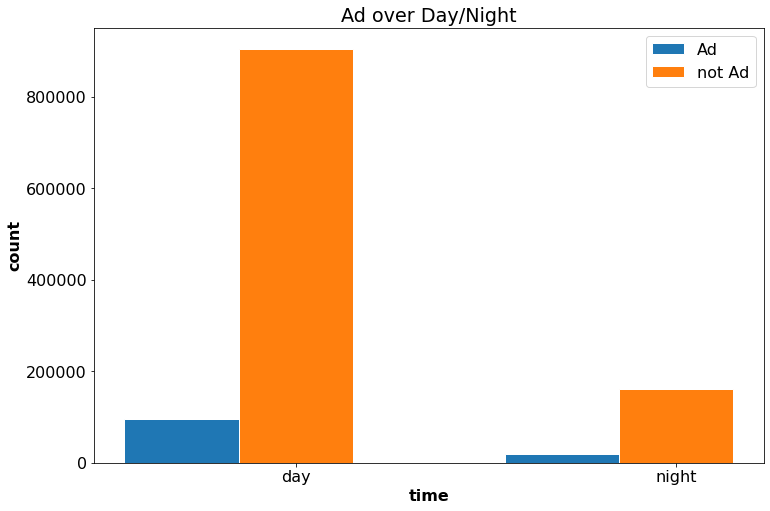

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    if p == "Ad":
        d = temp_df_day[temp_df_day.is_ad]
        n = temp_df_night[temp_df_night.is_ad]
    else:
        d = temp_df_day[~temp_df_day.is_ad]
        n = temp_df_night[~temp_df_night.is_ad]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    plt.bar(r, bar, width=barWidth, edgecolor='white', label=v)

plt.title("Ad over Day/Night")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["day", "night"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()


## Device Type Aggreagations

In [23]:
def get_device_type(d):
    if "iphone" in d:
        return "phone"
    if "samsung" in d:
        return "phone"
    if "projector" in d:
        return "IoT"
    if "switch" in d:
        return "IoT"
    if "watch" in d:
        return "IoT"
    if "macbook" in d:
        return "computer"
    if "windows" in d:
        return "computer"
    if "ipad" in d:
        return "tablet"
    if "tablet" in d:
        return "tablet"
    return "other"

all_df["device_type"] = all_df["device"].apply(get_device_type)
all_devices = all_df["device_type"].unique()

### Protocol Name

In [26]:
temp_df = all_df.groupby(["device_type", "is_ad"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()


temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [28]:
temp_df

,device_type,is_ad,count
0,IoT,False,1055
2,computer,False,719352
3,computer,True,26348
4,other,False,35048
5,other,True,1044
6,phone,False,301212
7,phone,True,87645
8,tablet,False,10876
9,tablet,True,962


In [29]:
5242/ 383615 * 100

1.3664741993926204

In [30]:
u_protocol_names = ["Ad", "not Ad"]

temp_dfs = [temp_df[temp_df.device_type == dt].copy() for dt in all_devices]

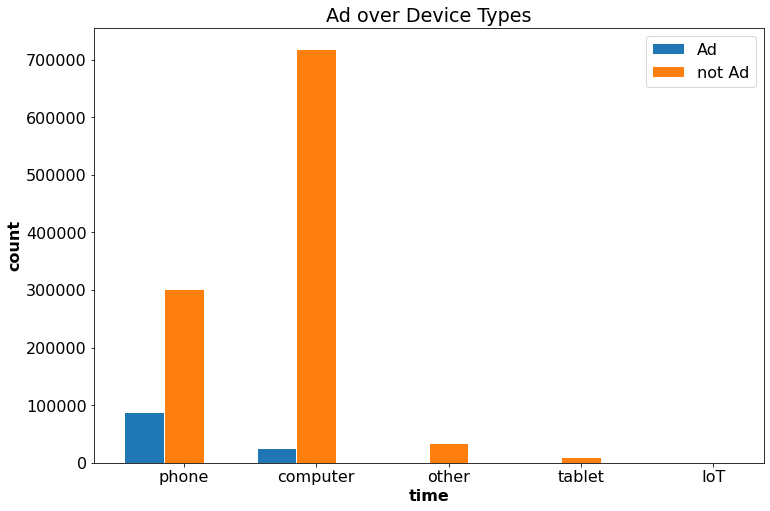

In [31]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    tl = []
    for t in temp_dfs:
        d = t[~t.is_ad]
        if p == "Ad":
            d = t[t.is_ad]
        tl.append(d.iloc[0]["count"] if len(d) else 0)
    bars.append(tl)
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    plt.bar(r, bar, width=barWidth, edgecolor='white', label=v)

plt.title("Ad over Device Types")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], all_devices)
 
# # Create legend & Show graphic
plt.legend()
plt.show()


In [34]:
def is_idle(t):
    if t.hour in [3, 4, 5, 6, 12]: # We could not log the idle and active times :( night and lunch break
        return True
    return False

all_df["is_idle"] = all_df.date_locale.apply(is_idle)

### Idle

In [35]:
temp_df = all_df.groupby(["is_idle", "is_ad"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [36]:
u_protocol_names = ["Ad", "not Ad"]

temp_df_day = temp_df[~temp_df.is_idle].copy()
temp_df_night = temp_df[temp_df.is_idle].copy()

In [37]:
temp_df

,is_idle,is_ad,count
0,False,False,938118
1,False,True,98170
2,True,False,129425
3,True,True,17880


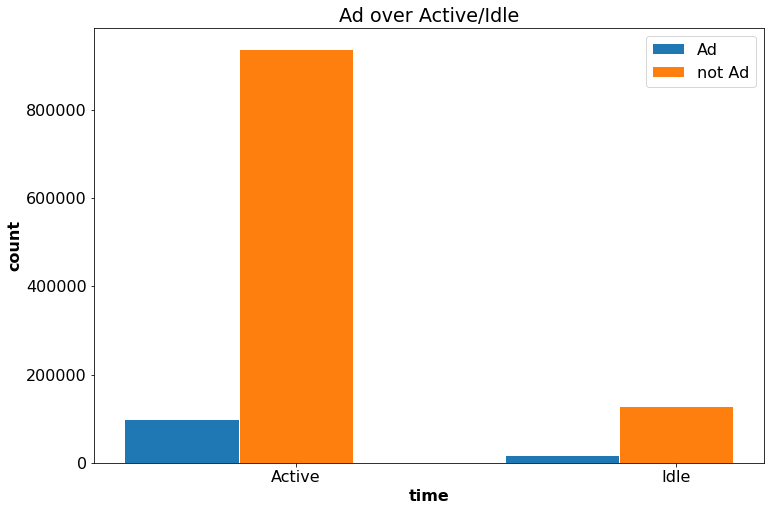

In [42]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    if p == "Ad":
        d = temp_df_day[temp_df_day.is_ad]
        n = temp_df_night[temp_df_night.is_ad]
    else:
        d = temp_df_day[~temp_df_day.is_ad]
        n = temp_df_night[~temp_df_night.is_ad]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    plt.bar(r, bar, width=barWidth, edgecolor='white', label=v)

plt.title("Ad over Active/Idle")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["Active", "Idle"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()
